# AI Model for predicitions

In [ ]:
pip install rasterio

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling

def load_and_resize_geotiff(file_path, new_shape):
    with rasterio.open(file_path) as src:
        # Read the original data
        data = src.read(1)
        new_height, new_width = new_shape

        # Prepare an empty array for the resized data
        data_resized = np.empty((new_height, new_width), dtype=rasterio.float32)

        # Perform the resampling (resampling method can be 'bilinear', 'nearest', etc.)
        reproject(
            source=data,
            destination=data_resized,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=src.transform * src.transform.scale(
                src.width / new_width,
                src.height / new_height
            ),
            dst_crs=src.crs,
            resampling=Resampling.bilinear
        )

        return data_resized


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
import numpy as np
import os
from rasterio.enums import Resampling

# Load a series of GeoTIFFs into a numpy array (time, height, width) with resizing
def load_timeseries_data(directory, new_shape):
    files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')])
    data = [load_and_resize_geotiff(f, new_shape) for f in files]
    return np.stack(data, axis=0)  # Stack images along the time axis

# Example usage: load time-series data from a directory with resizing
directory = '/content/drive/MyDrive/NASA Space Apps/Ocean Flux Data'

new_shape = (360, 720)  # Example of resizing to half the original size (721, 1440 -> 360, 720)
data = load_timeseries_data(directory, new_shape)

# Normalize the data for the model
data = data / np.max(data)  # Normalization step

In [ ]:
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(36, 360, 720)


In [ ]:
import numpy as np

# Assuming you have loaded 36 images into `image_list`
# Each image is of shape (height, width)
# Example: image_list[0].shape == (image_height, image_width)

# Parameters
sequence_length = 6  # Use 6 months to predict the next one

# Reshape images to include the channel dimension
# Shape after this step: (36, image_height, image_width, 1)
data = np.expand_dims(data, axis=-1)

# Prepare the sequences and corresponding labels
def create_sequences(images, seq_length):
    X = []
    y = []
    for i in range(len(images) - seq_length):
        # Input sequence of length 6 months
        X.append(images[i:i+seq_length])
        # Target is the next (7th) month
        y.append(images[i+seq_length])
    return np.array(X), np.array(y)

# Prepare the dataset
X, y = create_sequences(data, sequence_length)

# The shape of X will be (number_of_sequences, 6, image_height, image_width, 1)
# The shape of y will be (number_of_sequences, image_height, image_width, 1)

# Split the dataset into training and testing sets
train_size = 30  # Use the first 30 months for training
X_train, y_train = X[:train_size-sequence_length], y[:train_size-sequence_length]
X_val, y_val = X[train_size-sequence_length: -3], y[train_size-sequence_length: -3]

# Now, X_train and y_train are ready for training the ConvLSTM model
# X_train.shape -> (24, 6, image_height, image_width, 1) if training on the first 30 months
# X_val.shape -> (3, 6, image_height, image_width, 1) if testing on the last 3 months




In [ ]:
print(X.shape)
print(y.shape)

(30, 6, 360, 720, 1)
(30, 360, 720, 1)


In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
print(X_val.shape)
print(y_val.shape)

In [ ]:
from tensorflow.keras.models import load_model

model_file = '/content/drive/MyDrive/npp_model.h5'
model= load_model(model_file)


**The next Cell contains the model loaded. BUT it's trained on another dataset, and we load it to have initialized weights based on similar dataset instead of random weights**


In [ ]:
'''
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Input, Reshape
import h5py

# Define the input shape for (time_steps, height, width, channels)
input_shape = (6, 360, 720, 1)  # (time_steps, 360 height, 720 width, 1 channel)

# Input for the time series of images
inputs = Input(shape=input_shape)

# CNN block (apply the same CNN to each frame)
cnn = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(inputs)
cnn = TimeDistributed(MaxPooling2D((2, 2)))(cnn)
cnn = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(cnn)
cnn = TimeDistributed(MaxPooling2D((2, 2)))(cnn)

# Flatten the output of the CNN
cnn = TimeDistributed(Flatten())(cnn)

# LSTM block (process the sequence of CNN outputs)
lstm_out = LSTM(128, return_sequences=False, activation='tanh')(cnn)

# Fully connected layer to map LSTM output to the future image
dense = Dense(360 * 720, activation='sigmoid')(lstm_out)

# Reshape the output to match the new image dimensions (360x720)
outputs = Reshape((360, 720, 1))(dense)

# Create the model
model = Model(inputs=inputs, outputs=outputs)



'''

In [ ]:
#metrics to evaluate
import tensorflow as tf

#Structural Similarity Index (SSIM):
#SSIM values range from -1 to 1, where 1 indicates perfect similarity between the predicted and actual images.
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
#peak signal to noise ratio
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Set the learning rate to a custom value
learning_rate = 1.0  # You can adjust this value

# Create the Adam optimizer with the custom learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom learning rate optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[ssim_metric, psnr_metric])

In [ ]:
# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 6, 360, 720, 1)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 6, 360, 720, 16)     │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 6, 180, 360, 16)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 6, 180, 360, 32)     │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 6, 90, 180, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 6, 518400)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │     265,486,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 259200)              │      33,436,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 360, 720, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,928,448 (1.11 GB)

 Trainable params: 298,928,448 (1.11 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert your NumPy arrays to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Batch and prefetch the training dataset
train_dataset = (train_dataset
                 .batch(batch_size=2)                # Set the batch size
                 .prefetch(tf.data.AUTOTUNE))       # Prefetching to improve performance

# Prepare the validation dataset
val_dataset = (val_dataset
               .batch(batch_size=2)                # Set the batch size
               .prefetch(tf.data.AUTOTUNE))       # Prefetching to improve performance



In [ ]:
# Train the model with the new dataset
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 452s 37s/step - loss: 61624786944.0000 - psnr_metric: -107.8975 - ssim_metric: 0.4337 - val_loss: 61624778752.0000 - val_psnr_metric: -107.8975 - val_ssim_metric: 0.4353
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 456s 38s/step - loss: 61624782848.0000 - psnr_metric: -107.8975 - ssim_metric: 0.4338 - val_loss: 61624778752.0000 - val_psnr_metric: -107.8975 - val_ssim_metric: 0.4353
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 510s 38s/step - loss: 61624782848.0000 - psnr_metric: -107.8975 - ssim_metric: 0.4338 - val_loss: 61624778752.0000 - val_psnr_metric: -107.8975 - val_ssim_metric: 0.4353
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 470s 36s/step - loss: 61624782848.0000 - psnr_metric: -107.8975 - ssim_metric: 0.4338 - val_loss: 61624778752.0000 - val_psnr_metric: -107.8975 - val_ssim_metric: 0.4353
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 431s 36s/step - loss: 61624782848.0000 - psnr_metric: -107.8975 - ssim_metric: 0.4338 - val_loss: 61624778752.0000 - val_psnr_metr

In [ ]:
X_test, y_test = X[-3: ], y[-3: ]

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance on test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 61624778752.0000 - psnr_metric: -107.8975 - ssim_metric: 0.4378
Test Loss: [61624778752.0, 0.4378083050251007, -107.89754486083984]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


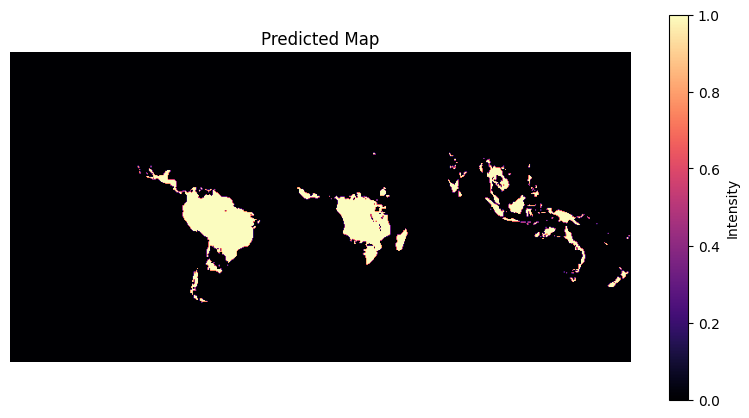

In [ ]:
#forecasting

input_sequence = data[-7:-1]
input_sequence = input_sequence.reshape(1, 6, 360, 720, 1)
predicted_image = model.predict(input_sequence)  # Predict for the first sequence in the validation set

import matplotlib.pyplot as plt

# Assuming 'predicted_image' has shape (1, 360, 720, 1)
# Remove the extra dimensions
predicted_image = predicted_image.squeeze()  # This will convert it to shape (360, 720)

# Now you can plot the predicted image
plt.figure(figsize=(10, 5))  # Set the figure size
plt.imshow(predicted_image, cmap='magma')  # Use your preferred colormap
plt.colorbar(label='Intensity')  # Add a colorbar for reference
plt.title('Predicted Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('off')  # Optionally turn off the axis for a cleaner look
plt.show()  # Display the plot



**NOT BEST RESUITS. But TerraTales (our team) works on Improvments**